In [1]:
from numpy import random
import numpy as np
import sympy
import scipy
from tteVAMP.problem import *
from tteVAMP.utils import *
from tteVAMP.vamp import *

In [17]:
# Euler -Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno_Weibull(X, beta, mu, h2, censoring):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    mask = np.zeros(n)

    if censoring > 0:
        n = len(y)
        censor_len = int(censoring * n)
        
        # Generate random factors between 0 and 1
        random_factors = np.random.uniform(0.01, 0.5, censor_len)
        
        # Apply censoring to the last censor_len positions
        y[-censor_len:, 0] = y[-censor_len:, 0] * random_factors
        
        # Create mask vector
        mask[-censor_len:] = 1


    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha, mask

def sim_pheno_ExpGamma(X, beta, mu, h2, kappa):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigmaE = np.sqrt( (1/h2-1) * sigmaG )
    theta = sigmaE / scipy.special.polygamma(1, kappa)
    # mu tilde
    mut = mu + g - theta * scipy.special.polygamma(0, kappa)
    y = random.gamma(shape=kappa, scale=theta, size=[n,1]) + mut
    return y, kappa, theta, mut

def sim_pheno_LogNormal(X, beta, mu, h2):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigma = np.sqrt( (1/h2-1) * sigmaG )
    w = random.normal(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp(mu + g + sigma * w)
    return y, sigma
    
def sim_model(problem,h2,p, kappa=None, censoring=0):
    n, m, la = problem.n, problem.m, problem.prior_instance.la
    # X = sim_geno(problem.n, problem.m, p)
    # beta = sim_beta(problem.m, problem.prior_instance.la, problem.prior_instance.sigmas)
    # mu = np.zeros((problem.n,1))
    # print(problem.model)
    mu=np.full((n,1), 0) 
    X = sim_geno(n,m,p)
    column_means = np.nanmean(X, axis=0)
    column_stds = np.nanstd(X, axis=0)
    print(f"Are standard deviations valid? {not 0 in column_stds}")
    X = (X - column_means) / column_stds
    X = np.nan_to_num(X)
    beta = sim_beta(m, la, h2/m/la)

    if problem.model == 'Weibull':
        y, alpha, mask = sim_pheno_Weibull(X, beta, mu, h2, censoring)
        return X, beta, y, alpha, mask
    elif problem.model == 'Gamma':
        return X, beta, sim_pheno_ExpGamma(X, beta, mu, h2, kappa)
    elif problem.model == 'LogNormal':
        return X, beta, sim_pheno_LogNormal(X, beta, mu, h2)
    else:
        raise Exception(problem.model, " is not a valid model. Allowed models are: 'Weibull', 'Gamma' and 'LogNormal'")
    

Onsager

In [92]:
def iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, zc, yc, mu, gamma_e, A_c, iters):
    m = A_c.shape[1]
    def equation(zc, const, gamma_e, beta_hat, A_c, idx):
        h = alpha * zc - const[idx]
        return 2 * gamma_e * (zc - np.dot(A_c[idx, :], beta_hat)) - alpha * np.exp(h) / (np.exp(np.exp(h)) - 1)
    
    const = alpha * np.log(yc) - alpha * mu - emc
    diff = alpha * zc - const
    # print(diff.shape)
    diff = diff.squeeze(-1)
    # print(max(diff), min(diff))
    print(sorted(diff, reverse=True)[:10])
    for _ in range(iters):
        # Solve linear system given zc = Ac@beta
        # print(f"Ac shape: {A_c.shape}")
        # print(f"zc.shape: {zc.shape}")
        # print(f"r2 shape: {r2.shape}")
        # comp1 = 
        # rhs = np.block([[comp1],[tau2*p2]])
        rhs = np.vstack((gam2 * r2 + gamma_e * A_c.T @ zc, tau2*p2))
        stacked = M_inv @ rhs
        # print(f"M_inv shape: {M_inv.shape}")
        # print(f"rhs shape: {rhs.shape}")
        beta_hat = stacked[:m, :]
        z_hat = stacked[m:, :]
        zc_initial_guess = zc
        zc_solutions = np.zeros_like(zc_initial_guess)
        for i in range(len(zc_initial_guess)):
            zc_solutions[i] = scipy.optimize.fsolve(equation, x0=zc_initial_guess[i], args=(const, gamma_e, beta_hat, A_c, i,))
        zc = zc_solutions
    return z_hat, beta_hat, zc


def block_matrix_inverse(gamma_e, gam2, tau2, X, X_c):
    # Dimensions
    n, p = X.shape
    n_c, _ = X_c.shape
    # Identity matrices
    I_p = np.eye(p)
    I_n = np.eye(n)
    # Compute A, B, C, D
    A = gamma_e * (X.T @ X + X_c.T @ X_c) + gam2 * I_p
    B = -gamma_e * X.T
    C = -gamma_e * X
    D = (gamma_e + tau2) * I_n
    # Compute A_inv
    A_inv = np.linalg.inv(A)
    # Compute S = D - CA_invB
    S = D - C @ A_inv @ B
    # Compute S_inv
    S_inv = np.linalg.inv(S)
    # Compute the block inverse
    top_left = A_inv + A_inv @ B @ S_inv @ C @ A_inv
    top_right = -A_inv @ B @ S_inv
    bottom_left = -S_inv @ C @ A_inv
    bottom_right = S_inv
    M_inv = np.block([
    [top_left, top_right],
    [bottom_left, bottom_right]
    ])
    return M_inv

def infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha, gamma_e=1e3):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # Note that this is not exactly a correlation
            # Instead this is an alignment score
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            # corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            # print("corr(x1_hat, beta_true) = ", corr[0, 1])
            # corrs_x.append(corr[0, 1])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # Just as above, this is an alignment score, not correlation
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        # corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        # print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        # corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        M_inv = block_matrix_inverse(gamma_e, gam2, tau2, X, X_c)
        Q = gamma_e*tau2/(gamma_e+tau2)*X.T@X + gamma_e*X_c.T@X_c + gam2*np.eye(m)
        Q_inv = np.linalg.inv(Q)
        # trace_M_inv = np.trace(M_inv)
        if it == 0: zc_hat = X_c@x1_hat
        else: zc_hat = z_c
        z2_hat, x2_hat, z_c = iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, X_c@x1_hat, y_c, mu, gamma_e, X_c, 50)
        alpha2 = gam2 / m * np.trace(Q_inv)
        
        print("->LMMSE")
        # dk = 1.0 / (tau2 * s * s + gam2)
        # x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        # r1, p1 = x2_hat, z2_hat
        
        # LMMSE estimation of z
        # z2_hat = np.matmul(X, x2_hat)

        # mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        # problem.prior_instance.distribution_parameters['alpha'] = alpha
        # problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################
        
        beta2 = tau2/(gamma_e+tau2) + ((gamma_e**2)*tau2/(gamma_e+tau2)**2)/n * np.trace(X@Q_inv@X.T)
        # beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    save_results('outputs', 
                 n,
                 m,
                 x1_hat=x1_hat, 
                 gam1=gam1, 
                 corrs_x=corrs_x, 
                 l2_errs_x=l2_errs_x, 
                 corrs_z=corrs_z, 
                 l2_errs_z=l2_errs_z, 
                 mus=mus, 
                 alphas=alphas, 
                 actual_xis=actual_xis, 
                 predicted_xis=predicted_xis, 
                 dl_dmus=dl_dmus, 
                 z1_hats=z1_hats, 
                 x1_hats=x1_hats)
    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats

np.random.seed(42)
n=800
m=200
p=0.4
la=0.05
# originally la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
# originally h2=0.5
h2=0.9
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 10
censoring = 0.99

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha,mask = sim_model(problem_instance,h2,p,censoring=censoring)
X_c, y_c, X, y = X[mask==1], y[mask==1], X[mask==0], y[mask==0]
n, m = X.shape

# problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha
est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, False)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m, f"Working with {n}x{m} matrix; censoring level: {censoring}")

Are standard deviations valid? True
gam1 =  0.01
tau1 =  0.1
alpha =  3.813585370534916
s.shape =  (8,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.04976421]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00049271]
alpha2 part II =  [0.]
alpha1 =  0.0004927149309449356
true gam2 =  203.68071999961433
gam2 =  20.28571131693099
corr(z1_hat, X*beta_true) =  0.7294576669124315
l2 error for z1_hat =  0.7118641712060447
v1 =  0.2925390204885969
true tau2 =  1.2689079403006058
tau2 = 0.2418347399706904
[22.26811180777463, 22.05620240294188, 21.812759880305197, 21.76927128161631, 20.32612163142506, 20.269080704024258, 20.114193711879135, 19.06278821553323, 18.900452585240103, 18.774366900221214]


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/2486029239.py:5: RuntimeWarning: overflow encountered in exp
  return 2 * gamma_e * (zc - np.dot(A_c[idx, :], beta_hat)) - alpha * np.exp(h) / (np.exp(np.exp(h)) - 1)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/2486029239.py:29: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  zc_solutions[i] = scipy.optimize.fsolve(equation, x0=zc_initial_guess[i], args=(const, gamma_e, beta_hat, A_c, i,))


No onsager

Are standard deviations valid? True
gam1 =  0.01
tau1 =  0.1
alpha =  3.813585370534916
s.shape =  (200,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.04976421]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00049271]
alpha2 part II =  [0.]
alpha1 =  0.0004927149309449356
true gam2 =  203.68071999961433
gam2 =  20.28571131693099


/Users/alexanders/vampW/tteVAMP/denoisers.py:100: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6843097086431797
l2 error for z1_hat =  0.729260108790696
v1 =  0.16272638345201526
true tau2 =  2.187908845211794
tau2 = 0.5145284979524417
[16.036560578864247, 15.563919826731329, 14.13627428440073, 12.716712018287671, 12.681496434719492, 12.277414294340211, 12.109534064257613, 12.06097912218822, 12.00855217328936, 11.794434277315228]


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/2528322949.py:5: RuntimeWarning: overflow encountered in exp
  return 2 * gamma_e * (zc - np.dot(A_c[idx, :], beta_hat)) - alpha * np.exp(h) / (np.exp(np.exp(h)) - 1)


->LMMSE
corr(x2_hat, beta_true) =  [[0.74436633]]
l2 error for x2_hat =  0.7158616797726806
**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-2.37365136e-06]
corr(x1_hat, beta_true) =  0.7443666837475125
l2 error for x1_hat =  0.9998216150357992
B / (A+B) =  [0.04976421]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00049271]
alpha2 part II =  [9.00932168e-12]
alpha1 =  0.0004927150121627355
true gam2 =  203.68072007599443
gam2 =  20.285707971441244
corr(z1_hat, X*beta_true) =  0.8510778497258112
l2 error for z1_hat =  0.5276122534427296
v1 =  0.08979635328736973
true tau2 =  3.5335370200634335
tau2 = 1.0136309698454697
[15.91581934991589, 15.15714908802115, 13.884221574036033, 12.977216552706874, 12.463585660878127, 12.177391311179592, 12.030507560658116, 11.84145042034506, 11.825197960375586, 11.475293636431507]
->LMMSE
corr(x2_hat, beta_true) =  [[0.80823837]]
l2 error for x2_hat =  0.6088791084574157
**** iteration =  2  **** 

->DENOISING
x1_hat[2] =  [1

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/2528322949.py:29: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  zc_solutions[i] = scipy.optimize.fsolve(equation, x0=zc_initial_guess[i], args=(const, gamma_e, beta_hat, A_c, i,))


->LMMSE
corr(x2_hat, beta_true) =  [[0.94178212]]
l2 error for x2_hat =  0.3435509888452575
**** iteration =  9  **** 

->DENOISING
x1_hat[2] =  [4.82054857e-07]
corr(x1_hat, beta_true) =  0.9417825045283671
l2 error for x1_hat =  0.9995957415993098
B / (A+B) =  [0.04976421]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00049271]
alpha2 part II =  [1.30151475e-11]
alpha1 =  0.000492715191489977
true gam2 =  203.6807209362283
gam2 =  20.2857005846722
corr(z1_hat, X*beta_true) =  0.9466829271950189
l2 error for z1_hat =  0.32314961542196624
v1 =  0.03409779323354865
true tau2 =  9.59714171257149
tau2 = 2.8327411106948266
[15.453652482274455, 13.12222636923233, 13.09835098969746, 11.520941158734033, 11.487165880011778, 11.377176358989296, 10.960887957923882, 10.91858903500884, 10.90146781813557, 10.365590060518265]
->LMMSE
corr(x2_hat, beta_true) =  [[0.95125926]]
l2 error for x2_hat =  0.3168915908617156
Saving results!!






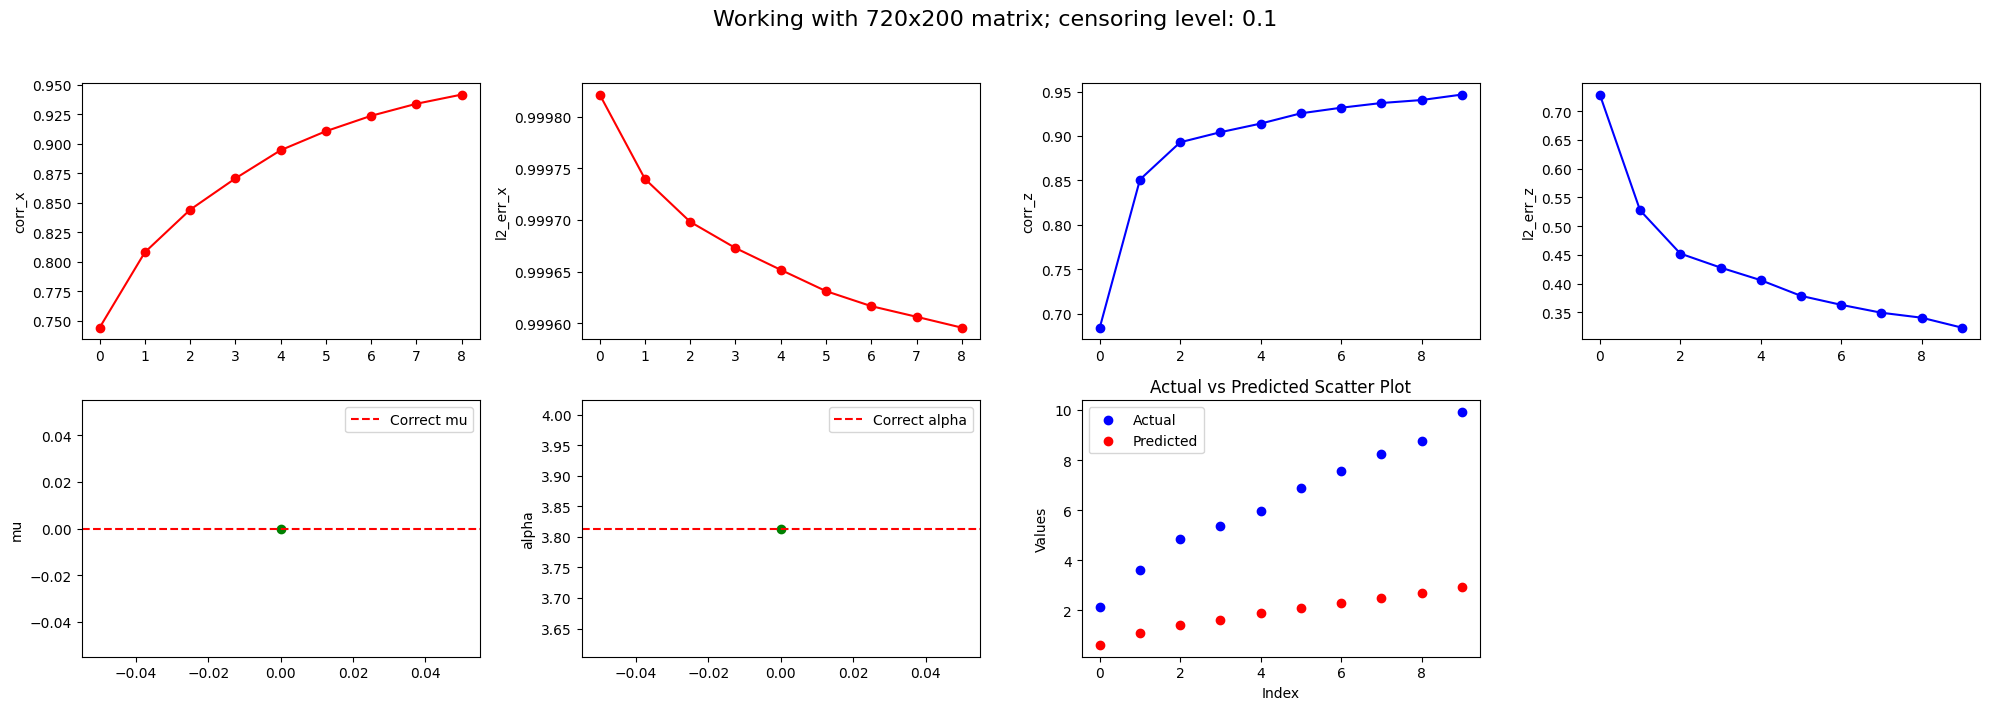

In [91]:
def iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, zc, yc, mu, gamma_e, A_c, iters):
    m = A_c.shape[1]
    def equation(zc, const, gamma_e, beta_hat, A_c, idx):
        h = alpha * zc - const[idx]
        return 2 * gamma_e * (zc - np.dot(A_c[idx, :], beta_hat)) - alpha * np.exp(h) / (np.exp(np.exp(h)) - 1)
    
    const = alpha * np.log(yc) - alpha * mu - emc
    diff = alpha * zc - const
    # print(diff.shape)
    diff = diff.squeeze(-1)
    # print(max(diff), min(diff))
    print(sorted(diff, reverse=True)[:10])
    for _ in range(iters):
        # Solve linear system given zc = Ac@beta
        # print(f"Ac shape: {A_c.shape}")
        # print(f"zc.shape: {zc.shape}")
        # print(f"r2 shape: {r2.shape}")
        # comp1 = 
        # rhs = np.block([[comp1],[tau2*p2]])
        rhs = np.vstack((gam2 * r2 + gamma_e * A_c.T @ zc, tau2*p2))
        stacked = M_inv @ rhs
        # print(f"M_inv shape: {M_inv.shape}")
        # print(f"rhs shape: {rhs.shape}")
        beta_hat = stacked[:m, :]
        z_hat = stacked[m:, :]
        zc_initial_guess = zc
        zc_solutions = np.zeros_like(zc_initial_guess)
        for i in range(len(zc_initial_guess)):
            zc_solutions[i] = scipy.optimize.fsolve(equation, x0=zc_initial_guess[i], args=(const, gamma_e, beta_hat, A_c, i,))
        zc = zc_solutions
    return z_hat, beta_hat, zc


def block_matrix_inverse(gamma_e, gam2, tau2, X, X_c):
    # Dimensions
    n, p = X.shape
    # Identity matrices
    I_p = np.eye(p)
    I_n = np.eye(n)
    # Compute A, B, C, D
    A = gamma_e * (X.T @ X + X_c.T @ X_c) + gam2 * I_p
    B = -gamma_e * X.T
    C = -gamma_e * X
    D = (gamma_e + tau2) * I_n
    # Compute A_inv
    A_inv = np.linalg.inv(A)
    # Compute S = D - CA_invB
    S = D - C @ A_inv @ B
    # Compute S_inv
    S_inv = np.linalg.inv(S)
    # Compute the block inverse
    top_left = A_inv + A_inv @ B @ S_inv @ C @ A_inv
    top_right = -A_inv @ B @ S_inv
    bottom_left = -S_inv @ C @ A_inv
    bottom_right = S_inv
    M_inv = np.block([
    [top_left, top_right],
    [bottom_left, bottom_right]
    ])
    return M_inv

def infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha, gamma_e=1e3):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # Note that this is not exactly a correlation
            # Instead this is an alignment score
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            # corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            # print("corr(x1_hat, beta_true) = ", corr[0, 1])
            # corrs_x.append(corr[0, 1])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # Just as above, this is an alignment score, not correlation
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        # corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        # print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        # corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        M_inv = block_matrix_inverse(gamma_e, gam2, tau2, X, X_c)
        trace_M_inv = np.trace(M_inv)
        if it == 0: zc_hat = X_c@x1_hat
        else: zc_hat = z_c
        z2_hat, x2_hat, z_c = iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, zc_hat, y_c, mu, gamma_e, X_c, 50)
        alpha2 = gam2 / m * trace_M_inv
        
        print("->LMMSE")
        # dk = 1.0 / (tau2 * s * s + gam2)
        # x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        # alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        # print("alpha2 = ", alpha2)
        # gam1 = gam2 * (1-alpha2) / alpha2
        # r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        # print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        # print("gam1 = ", gam1)
        r1, p1 = x2_hat, z2_hat
        
        # LMMSE estimation of z
        # z2_hat = np.matmul(X, x2_hat)

        # mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        # problem.prior_instance.distribution_parameters['alpha'] = alpha
        # problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        # ############################################################
        # # Cosine similarity
        # print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        # print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        # ############################################################
        # beta2 = tau2 / m *trace_M_inv
        # # beta2 = (1-alpha2) * m / n
        # tau1 = tau2 * (1-beta2) / beta2
        # p1 = (z2_hat - beta2 * p2) / (1-beta2)
        # print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        # print("tau1 = ", tau1)
        # print("\n")

    save_results('outputs', 
                 n,
                 m,
                 x1_hat=x1_hat, 
                 gam1=gam1, 
                 corrs_x=corrs_x, 
                 l2_errs_x=l2_errs_x, 
                 corrs_z=corrs_z, 
                 l2_errs_z=l2_errs_z, 
                 mus=mus, 
                 alphas=alphas, 
                 actual_xis=actual_xis, 
                 predicted_xis=predicted_xis, 
                 dl_dmus=dl_dmus, 
                 z1_hats=z1_hats, 
                 x1_hats=x1_hats)
    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats

np.random.seed(42)
n=800
m=200
p=0.4
la=0.05
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.9
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 10
censoring = 0.1

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha,mask = sim_model(problem_instance,h2,p,censoring=censoring)
X_c, y_c, X, y = X[mask==1], y[mask==1], X[mask==0], y[mask==0]
n, m = X.shape

# problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha
est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, False)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m, f"Working with {n}x{m} matrix; censoring level: {censoring}")

In [77]:
def iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, zc, yc, mu, gamma_e, A_c, iters):
    m = A_c.shape[1]
    def equation(zc, const, gamma_e, beta_hat, A_c, idx):
        h = alpha * zc - const[idx]
        return 2 * gamma_e * (zc - np.dot(A_c[idx, :], beta_hat)) - alpha * np.exp(h) / (np.exp(np.exp(h)) - 1)
    
    const = alpha * np.log(yc) - alpha * mu - emc
    for _ in range(iters):
        # Solve linear system given zc = Ac@beta
        # print(f"Ac shape: {A_c.shape}")
        # print(f"zc.shape: {zc.shape}")
        # print(f"r2 shape: {r2.shape}")
        # comp1 = 
        # rhs = np.block([[comp1],[tau2*p2]])
        rhs = np.vstack((gam2 * r2 + gamma_e * A_c.T @ zc, tau2*p2))
        stacked = M_inv @ rhs
        # print(f"M_inv shape: {M_inv.shape}")
        # print(f"rhs shape: {rhs.shape}")
        beta_hat = stacked[:m, :]
        z_hat = stacked[m:, :]
        zc_initial_guess = zc
        zc_solutions = np.zeros_like(zc_initial_guess)
        for i in range(len(zc_initial_guess)):
            zc_solutions[i] = scipy.optimize.fsolve(equation, x0=zc_initial_guess[i], args=(const, gamma_e, beta_hat, A_c, i,))
        zc = zc_solutions
    return z_hat, beta_hat, zc


def block_matrix_inverse(gamma_e, gam2, tau2, X, X_c):
    # Dimensions
    n, p = X.shape
    n_c, _ = X_c.shape
    # Identity matrices
    I_p = np.eye(p)
    I_n = np.eye(n)
    # Compute A, B, C, D
    A = gamma_e * (X.T @ X + X_c.T @ X_c) + gam2 * I_p
    B = -gamma_e * X.T
    C = -gamma_e * X
    D = (gamma_e + tau2) * I_n
    # Compute A_inv
    A_inv = np.linalg.inv(A)
    # Compute S = D - CA_invB
    S = D - C @ A_inv @ B
    # Compute S_inv
    S_inv = np.linalg.inv(S)
    # Compute the block inverse
    top_left = A_inv + A_inv @ B @ S_inv @ C @ A_inv
    top_right = -A_inv @ B @ S_inv
    bottom_left = -S_inv @ C @ A_inv
    bottom_right = S_inv
    M_inv = np.block([
    [top_left, top_right],
    [bottom_left, bottom_right]
    ])
    return M_inv

def infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha, gamma_e=1e3):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true
    z_c_hat = None

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []

    constant1 = alpha * np.log(y_c) - alpha*mu-emc
    constant1_squeezed = constant1.squeeze(-1)

    def jacobian(z_c):
        diff = alpha*z_c-constant1_squeezed
        # print(diff)
        print(f"The range of differences: {min(diff), max(diff)}")
        double_exp = np.exp(np.exp(diff))-1
        # print(min(double_exp), print(max(double_exp)))
        single_exp = np.exp(diff)
        vec_nonlinear = alpha * (single_exp * double_exp - (single_exp**2) * double_exp) / (double_exp**2) 
        # vec_nonlinear = vec_nonlinear.squueze(-1)
        # print(f"Vec nonlinear: {vec_nonlinear.shape}")
        # print(vec_nonlinear)
        # print(0 in vec_nonlinear)
        jacobian = np.diag(vec_nonlinear)
        # print(f"Jacobian: {jacobian.shape}")
        # print(jacobian)

        return jacobian
    
    corr_uncensored = X.T@X
    n_c, _ = X_c.shape

    def f(z_c): 
        r = np.exp(alpha*z_c - constant1_squeezed) / (np.exp(np.exp(alpha*z_c-constant1_squeezed)) - 1)
        # print(r.shape)
        return r

    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # Note that this is not exactly a correlation
            # Instead this is an alignment score
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            # corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            # print("corr(x1_hat, beta_true) = ", corr[0, 1])
            # corrs_x.append(corr[0, 1])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # Just as above, this is an alignment score, not correlation
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        # corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        # print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        # corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        # M_inv = block_matrix_inverse(gamma_e, gam2, tau2, X, X_c)
        # Q = gamma_e*tau2/(gamma_e+tau2)*X.T@X + gamma_e*X_c.T@X_c + gam2*np.eye(m)
        # Q_inv = np.linalg.inv(Q)
        # # trace_M_inv = np.trace(M_inv)
        # z2_hat, x2_hat, z_c = iterative_solver(M_inv, alpha, r2, p2, gam2, tau2, X_c@x1_hat, y_c, mu, gamma_e, X_c, 50)
        # alpha2 = gam2 / m * np.trace(Q_inv)
        
        print("->LMMSE")
        if it==0: 
            z_c_hat = constant1_squeezed/alpha*np.random.uniform(0.98, 0.99, n_c)

        jac = jacobian(z_c_hat)

        f_z = f(z_c_hat)
        # print(f_z)
        # print(f_z.shape)
        # print(f"Jac shape: {jac.shape}")
        const_3 = (alpha/2)*(f_z - jac@z_c_hat)
        jac_inv = np.linalg.inv(jac)
        S = tau2 * corr_uncensored + tau2 * np.eye(m) - (alpha/2)*X_c.T @ jac_inv @ X_c
        S_inv = np.linalg.inv(S)

        const_3 = const_3.reshape(n_c, 1)
        z_c_hat = X_c @ S_inv @ X_c.T @ const_3 + tau2 * X_c @ S_inv @ X.T @ p2 + gam2 * X_c @ S_inv @ r2
        z2_hat = X @ S_inv @ X_c.T @ const_3 + tau2 * X @ S_inv @ X.T @ p2 + gam2 * X @ S_inv @ r2
        x2_hat = S_inv @ X_c.T @ const_3 + tau2 * S_inv @ X.T @ p2 + gam2 * S_inv @ r2

        alpha2 = gam2 / m * np.trace(S_inv)
        beta2 = tau2 / n * np.trace(X @ S_inv @ X.T)

        # print((X @ S_inv @ X_c.T @ const_3).shape)
        # print((tau2 * X @ S_inv @ X.T @ p2).shape)
        # print((gam2 * X @ S_inv @ r2).shape)

        # print(x2_hat.shape)
        # print(z2_hat.shape)

        # x2_hat = x2_hat.reshape(m, 1)
        # z2_hat = z2_hat.reshape(n, 1)
        z_c_hat = z_c_hat.squeeze(-1)
        
        

        # dk = 1.0 / (tau2 * s * s + gam2)
        # x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        print(r1.shape)
        # r1, p1 = x2_hat, z2_hat
        
        # LMMSE estimation of z
        # z2_hat = np.matmul(X, x2_hat)

        # mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        # problem.prior_instance.distribution_parameters['alpha'] = alpha
        # problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################
        
        # beta2 = tau2/(gamma_e+tau2) + ((gamma_e**2)*tau2/(gamma_e+tau2)**2)/n * np.trace(X@Q_inv@X.T)
        # beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print(p1.shape)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    save_results('outputs', 
                 n,
                 m,
                 x1_hat=x1_hat, 
                 gam1=gam1, 
                 corrs_x=corrs_x, 
                 l2_errs_x=l2_errs_x, 
                 corrs_z=corrs_z, 
                 l2_errs_z=l2_errs_z, 
                 mus=mus, 
                 alphas=alphas, 
                 actual_xis=actual_xis, 
                 predicted_xis=predicted_xis, 
                 dl_dmus=dl_dmus, 
                 z1_hats=z1_hats, 
                 x1_hats=x1_hats)
    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats

np.random.seed(42)
n=800
m=200
p=0.4
la=0.05
# originally la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
# originally h2=0.5
h2=0.9
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 10
censoring = 0.1

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha,mask = sim_model(problem_instance,h2,p,censoring=censoring)
X_c, y_c, X, y = X[mask==1], y[mask==1], X[mask==0], y[mask==0]
n, m = X.shape

# problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha
est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, X_c, y_c, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, False)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m, f"Working with {n}x{m} matrix; censoring level: {censoring}")

Are standard deviations valid? True
gam1 =  0.01
tau1 =  0.1
alpha =  3.813585370534916
s.shape =  (200,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.04976421]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00049271]
alpha2 part II =  [0.]
alpha1 =  0.0004927149309449356
true gam2 =  203.68071999961433
gam2 =  20.28571131693099


/Users/alexanders/vampW/tteVAMP/denoisers.py:100: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6843097086431797
l2 error for z1_hat =  0.729260108790696
v1 =  0.16272638345201526
true tau2 =  2.187908845211794
tau2 = 0.5145284979524417
->LMMSE
The range of differences: (-0.06464427689213803, 0.24347477164529252)
corr(x2_hat, beta_true) =  [[0.76588327]]
l2 error for x2_hat =  0.6807000032896177
alpha2 =  0.0690176668647982
true gam1 =  456.4179723950972
gam1 =  273.63484900379933
(200, 1)
corr(z2_hat, beta_true) =  [[0.81605883]]
l2 error for z2_hat =  0.6470715106721904
(720, 1)
true tau1 =  2.0348610571286985
tau1 =  2.2476037122515766


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [1.59227619e-05]
corr(x1_hat, beta_true) =  0.7162397829565336
l2 error for x1_hat =  0.8296136542181777
B / (A+B) =  [0.00318553]
gam1 / (gam1 + 1/sigma) =  0.9963588015008752
alpha1 part I =  [0.00317393]
alpha2 part II =  [3.93219387e-05]
alpha1 =  0.040685177814990904
true gam2 =  287.58251934674
gam2 =  6452.029476419783
corr(z1_hat, X*beta_true) =  0.9417

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/1670150899.py:90: RuntimeWarning: overflow encountered in exp
  double_exp = np.exp(np.exp(diff))-1
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/1670150899.py:93: RuntimeWarning: overflow encountered in multiply
  vec_nonlinear = alpha * (single_exp * double_exp - (single_exp**2) * double_exp) / (double_exp**2)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/1670150899.py:93: RuntimeWarning: invalid value encountered in subtract
  vec_nonlinear = alpha * (single_exp * double_exp - (single_exp**2) * double_exp) / (double_exp**2)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/1670150899.py:93: RuntimeWarning: overflow encountered in square
  vec_nonlinear = alpha * (single_exp * double_exp - (single_exp**2) * double_exp) / (double_exp**2)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24213/1670150899.py:108: RuntimeWarning: overflow encountered in exp
  r =

LinAlgError: Singular matrix